In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")



## Final Test Score using F1 score: 0.53
## Model: LightGBM

In [2]:
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import shap
from sklearn.model_selection import RandomizedSearchCV
from lightgbm.sklearn import LGBMClassifier

<br><br>

In [3]:
cc_df = pd.read_csv('data/UCI_Credit_Card.csv', index_col=0)
display(cc_df)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29998,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Data splitting <a name="2"></a>
<hr>


In [4]:
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=123)

In [5]:
num_zero_payments = cc_df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].eq(0.0).any(axis=1).sum()
print(num_zero_payments)
zero_payments_df = cc_df[cc_df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].eq(0.0).any(axis=1)]
num_defaulted_with_zero_payments = zero_payments_df['default.payment.next.month'].sum()
print(num_defaulted_with_zero_payments)
print(cc_df['default.payment.next.month'].sum())


14542
4485
6636


In [6]:
cc_df.describe(include='all')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
print(f"Number of defaulters: {train_df[train_df['default.payment.next.month'] == 1].shape[0]}")
print(f"Number of non-defaulters: {train_df[train_df['default.payment.next.month'] == 0].shape[0]}")

print(f"Number of training examples: {train_df.shape[0]}")
print(f"Number of test examples: {test_df.shape[0]}")

limit_bal_summary = train_df.groupby('default.payment.next.month')['LIMIT_BAL'].agg(
    median_limit='median', 
    mean_limit='mean'
)

display(limit_bal_summary)


Number of defaulters: 4688
Number of non-defaulters: 16312
Number of training examples: 21000
Number of test examples: 9000


,median_limit,mean_limit
default.payment.next.month,,
0,150000.0,178297.940167
1,90000.0,131633.464164


Seeing the number of defaulters to non-defaulters is crucial for understanding that this dataset is heavily imbalanced. This must be considered later on when evaluating the effectiveness of our models.

In [8]:
# Filter for people who have defaulted
defaulted_df = cc_df[cc_df['default.payment.next.month'] == 1]

defaulted_df.describe(include='all')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,...,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.000000,6636.0
mean,130109.656420,1.567058,1.894665,1.528029,35.725738,0.668174,0.458258,0.362116,0.254521,0.167872,...,42036.950573,39540.190476,38271.435503,3397.044153,3388.649638,3367.351567,3155.626733,3219.139542,3441.482068,1.0
std,115378.540571,0.495520,0.728096,0.525433,9.693438,1.383252,1.502243,1.499401,1.508535,1.482833,...,64351.076092,61424.695949,59579.674268,9544.252427,11737.986064,12959.624486,11191.973162,11944.731175,13464.005894,0.0
min,10000.000000,1.000000,1.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-65167.000000,-53007.000000,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,...,2141.500000,1502.750000,1150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,90000.000000,2.000000,2.000000,2.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,19119.500000,18478.500000,18028.500000,1636.000000,1533.500000,1222.000000,1000.000000,1000.000000,1000.000000,1.0
75%,200000.000000,2.000000,2.000000,2.000000,42.000000,2.000000,2.000000,2.000000,2.000000,0.000000,...,50175.750000,47853.000000,47424.000000,3478.250000,3309.750000,3000.000000,2939.250000,3000.000000,2974.500000,1.0
max,740000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,7.000000,8.000000,8.000000,8.000000,...,548020.000000,547880.000000,514975.000000,300000.000000,358689.000000,508229.000000,432130.000000,332000.000000,345293.000000,1.0


In [9]:
# Filter for people who have not defaulted
not_defaulted_df = cc_df[cc_df['default.payment.next.month'] == 0]


not_defaulted_df.describe(include='all')


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,23364.000000,...,23364.000000,23364.000000,23364.000000,23364.000000,2.336400e+04,23364.000000,23364.000000,23364.000000,23364.000000,23364.0
mean,178099.726074,1.614150,1.841337,1.558637,35.417266,-0.211222,-0.301917,-0.316256,-0.355633,-0.389488,...,43611.165254,40530.445343,39042.268704,6307.337357,6.640465e+03,5753.496833,5300.529319,5248.220296,5719.371769,0.0
std,131628.359660,0.486806,0.806780,0.520794,9.077355,0.952464,1.035191,1.048378,1.013162,0.977591,...,64324.796730,60617.268112,59547.015717,18014.508990,2.530226e+04,18684.255937,16689.778060,16071.667860,18792.950473,0.0
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
25%,70000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2360.000000,1823.000000,1265.500000,1163.750000,1.005000e+03,600.000000,390.000000,369.000000,300.000000,0.0
50%,150000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19000.000000,17998.000000,16679.000000,2459.500000,2.247500e+03,2000.000000,1734.000000,1765.000000,1706.000000,0.0
75%,250000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55988.000000,51135.250000,49842.500000,5606.250000,5.311250e+03,5000.000000,4602.000000,4600.000000,4545.000000,0.0
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,7.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,0.0


In [10]:
average_bill = cc_df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1).mean()
average_payment = cc_df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1).mean()
print(f"Average percentage of bill paid: {round(average_payment * 100 / average_bill, 2)}%")

Average percentage of bill paid: 11.73%


In [11]:
average_bill_defaulter = defaulted_df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1).mean()
average_payment_defaulter = defaulted_df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1).mean()
print(f"Average percentage of bill paid by defaulter: {round(average_payment_defaulter * 100 / average_bill_defaulter, 2)}%")

Average percentage of bill paid by defaulter: 7.66%


In [12]:
average_bill_non_defaulter = not_defaulted_df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1).mean()
average_payment_non_defaulter = not_defaulted_df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1).mean()
print(f"Average percentage of bill paid by non-defaulter: {round(average_payment_non_defaulter * 100 / average_bill_non_defaulter, 2)}%")

Average percentage of bill paid by non-defaulter: 12.84%


Average percentage of bill paid separated by default groups can be useful to see the differences between each group and how it may affect each person's chances of defaulting.

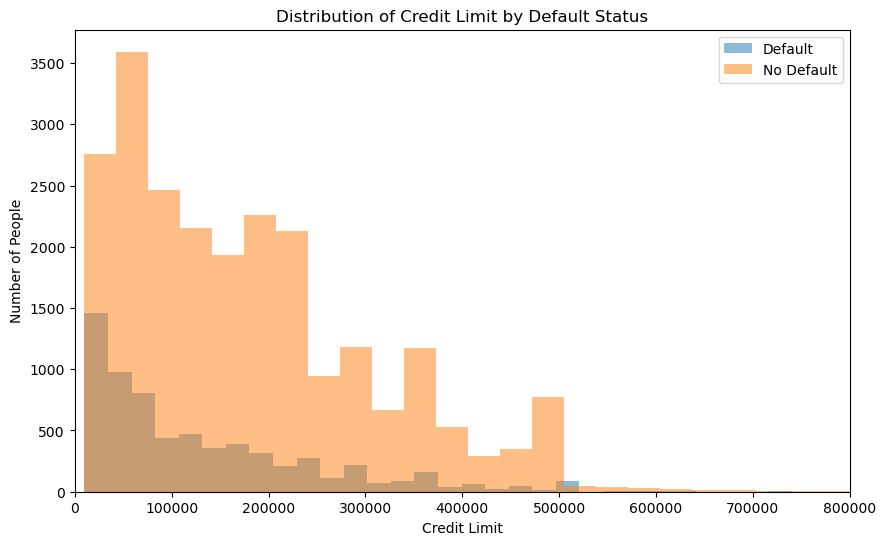

In [13]:
defaulted = cc_df[cc_df['default.payment.next.month'] == 1]['LIMIT_BAL']
not_defaulted = cc_df[cc_df['default.payment.next.month'] == 0]['LIMIT_BAL']

plt.figure(figsize=(10, 6))
plt.hist(defaulted, bins=30, alpha=0.5, label='Default')
plt.hist(not_defaulted, bins=30, alpha=0.5, label='No Default')
plt.title('Distribution of Credit Limit by Default Status')
plt.xlabel('Credit Limit')
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 800000)
plt.ylabel('Number of People')
plt.legend()
plt.show()




This visualization is useful to see the credit limits of people who do and don't default the following month.
It is clear that people who do default generally have much lower credit limits than people who don't default.

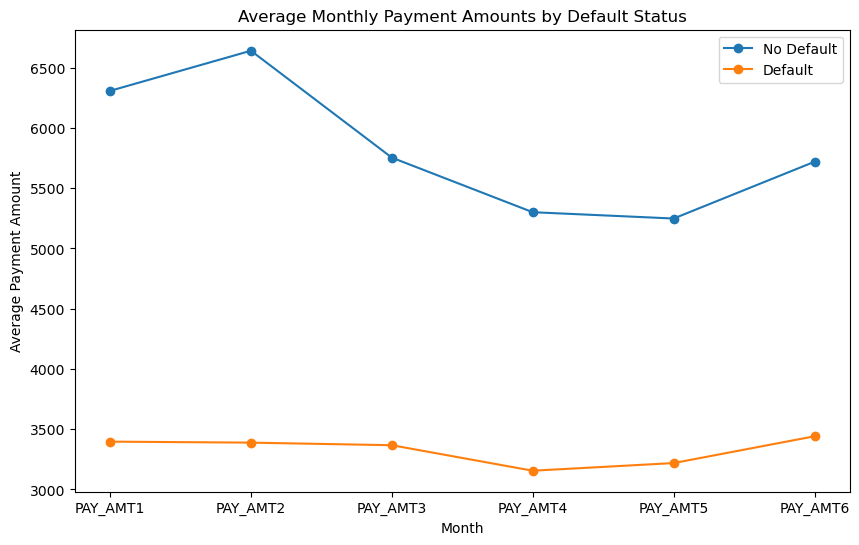

In [14]:
avg_payments = cc_df.groupby('default.payment.next.month')[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean()

plt.figure(figsize=(10, 6))
plt.plot(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], 
         avg_payments.loc[0], label='No Default', marker='o')
plt.plot(['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], 
         avg_payments.loc[1], label='Default', marker='o')
plt.title('Average Monthly Payment Amounts by Default Status')
plt.xlabel('Month')
plt.ylabel('Average Payment Amount')
plt.legend()
plt.show()


This visualization is useful to see that non-defaulters on average pay more per bill than defaulters do.

My intial observation about the dataset is that it's very imbalanced. There are clearly way more non-defaulters than defaulters. As such, accuracy will not be a very good metric for assessing models. We will likely f1 score instead, with weighting if appropriate.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Feature engineering <a name="4"></a>
<hr>


In [15]:

for i in range(1, 7):
    cc_df[f'utilization_rate_{i}'] = cc_df[f'BILL_AMT{i}'] / cc_df['LIMIT_BAL']
    # Counting late payments where PAY_X > 0, starting from PAY_0 (September) and going back to PAY_6 (April)
    if i == 2:
        continue
    cc_df['max_payment_delay'] = cc_df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].abs().max(axis=1)


# Calculate the average utilization rate across all months
cc_df['avg_utilization_rate'] = cc_df[[f'utilization_rate_{i}' for i in range(1, 7)]].mean(axis=1)

# Calculate average utilization rate by default status
average_credit_util_by_default = cc_df.groupby('default.payment.next.month')['avg_utilization_rate'].mean()

# Display results
print("Average credit utilization for each default group:")
print(average_credit_util_by_default)
display(cc_df)

# Check the shape of the DataFrame
cc_df.shape


Average credit utilization for each default group:
default.payment.next.month
0    0.351391
1    0.449298
Name: avg_utilization_rate, dtype: float64


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT6,default.payment.next.month,utilization_rate_1,max_payment_delay,utilization_rate_2,utilization_rate_3,utilization_rate_4,utilization_rate_5,utilization_rate_6,avg_utilization_rate
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,1,0.195650,2,0.155100,0.034450,0.000000,0.000000,0.000000,0.064200
2,120000.0,2,2,2,26,-1,2,0,0,0,...,2000.0,1,0.022350,2,0.014375,0.022350,0.027267,0.028792,0.027175,0.023718
3,90000.0,2,2,2,34,0,0,0,0,0,...,5000.0,0,0.324878,0,0.155856,0.150656,0.159233,0.166089,0.172767,0.188246
4,50000.0,2,2,1,37,0,0,0,0,0,...,1000.0,0,0.939800,0,0.964660,0.985820,0.566280,0.579180,0.590940,0.771113
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,679.0,0,0.172340,1,0.113400,0.716700,0.418800,0.382920,0.382620,0.364463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000.0,1,3,1,39,0,0,0,0,0,...,1000.0,0,0.858855,0,0.876432,0.947114,0.400018,0.141986,0.072636,0.549507
29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,0.0,0,0.011220,1,0.012187,0.023347,0.059860,0.034600,0.000000,0.023536
29998,30000.0,1,2,2,37,4,3,2,-1,0,...,3100.0,1,0.118833,4,0.111867,0.091933,0.695933,0.686067,0.645233,0.391644


(30000, 32)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Preprocessing and transformations <a name="5"></a>
<hr>


In [16]:
train_df_new, test_df_new = train_test_split(cc_df, test_size=0.3, random_state=123)
X_train, y_train = (train_df_new.drop(columns=["default.payment.next.month"]), train_df_new["default.payment.next.month"])
X_test, y_test = (test_df_new.drop(columns=["default.payment.next.month"]), test_df_new["default.payment.next.month"])

In [17]:
numeric_feats = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
                "utilization_rate_1", "utilization_rate_2", "utilization_rate_3", "utilization_rate_4", "utilization_rate_5", "utilization_rate_6", "avg_utilization_rate",
                "max_payment_delay"]
categorical_features = ["MARRIAGE"]
ordinal_features = ["EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
binary_features = ["SEX"]
drop_features = ["ID"]
target = "default.payment.next.month"

ordinal_categories = [
    [0, 1, 2, 3, 4, 5, 6],              # EDUCATION
    [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # PAY_0
    [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # PAY_2
    [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # PAY_3
    [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # PAY_4
    [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # PAY_5
    [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # PAY_6
]

ct = make_column_transformer((StandardScaler(), numeric_feats), 
                             (OneHotEncoder(handle_unknown = "ignore"), categorical_features), 
                             (OrdinalEncoder(categories=ordinal_categories), ordinal_features), 
                             (OneHotEncoder(drop="if_binary", dtype=int), binary_features),
                             remainder="drop")
pipeline = make_pipeline(ct, LogisticRegression(max_iter=500))


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Baseline model <a name="6"></a>
<hr>


In [18]:
dummy = DummyClassifier()

In [19]:
scores = cross_val_score(dummy, X_train, y_train, cv=10)
dummy_score = scores.mean()
display(dummy_score)

0.7767619047619047

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Linear models <a name="7"></a>
<hr>


The Logistic Regression model seems to perform a bit better than sklearn's base model in terms of accuracy. But, with the largely imbalanced data, we know that it is not a good measure of how good our model is so we have opted to tune our hyperparameters using the f1 score instead. After tuning, our accuracy scores are much lower, but the f1 score is much higher than without tuning. It does not look like there is overfitting to the training set. 
The best value of "C" to use seems to be 0.001.

In [20]:
results = {}
scoring_metric = ['accuracy', 'f1']

In [21]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross-validation scores
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    # Calculate the mean and standard deviation of the scores
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    # Use .iloc for position-based indexing to avoid the warning
    for i in range(len(mean_scores)):
        out_col.append(f"{mean_scores.iloc[i]:.3f} (+/- {std_scores.iloc[i]:.3f})")

    return pd.Series(data=out_col, index=mean_scores.index)


    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
param_distributions = {
    'logisticregression__C': np.logspace(-3, 2, num=6),
    'logisticregression__max_iter': np.arange(150, 551, 100),  # Creates [200, 300, 400, 500]
    'logisticregression__class_weight': [None, 'balanced']
}

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=48,
    cv=10,
    n_jobs=-1,
    return_train_score=True,
    scoring="f1",
    random_state=123
)

rs.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", rs.best_params_)
print("Best cross-validation score:", rs.best_score_)

Best parameters: {'logisticregression__max_iter': 150, 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.001}
Best cross-validation score: 0.5191146430974631


In [23]:
pipeline_unadjusted = make_pipeline(ct, LogisticRegression(max_iter=500))

## Input the hyperparameter values from the ones we just found above
pipeline_adjusted = make_pipeline(ct, LogisticRegression(C=0.001, max_iter=150, class_weight="balanced"))

results["Logistic Regression"] = mean_std_cross_val_scores(
    pipeline_unadjusted, X_train, y_train, cv=10, return_train_score=True, scoring=scoring_metric
)

results["Tuned Logistic Regression"] = mean_std_cross_val_scores(
    pipeline_adjusted, X_train, y_train, cv=10, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
Logistic Regression,0.125 (+/- 0.014),0.007 (+/- 0.000),0.813 (+/- 0.006),0.814 (+/- 0.001),0.414 (+/- 0.023),0.418 (+/- 0.006)
Tuned Logistic Regression,0.056 (+/- 0.002),0.007 (+/- 0.000),0.737 (+/- 0.009),0.738 (+/- 0.002),0.519 (+/- 0.012),0.519 (+/- 0.002)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Different models <a name="8"></a>
<hr>


In [24]:

best_score = 0
param_grid = {'max_depth': np.arange(1, 20, 1)}
r = {"max_depth": [], "mean_cv_score": []}

for depth in param_grid["max_depth"]:
    dt_pipe = make_pipeline(ct, DecisionTreeClassifier(max_depth=depth))
    scores1 = cross_val_score(dt_pipe, X_train, y_train, cv=10)
    mean_score = np.mean(scores1)
    
    r["max_depth"].append(depth)
    r["mean_cv_score"].append(mean_score)
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = {"max_depth": depth}

print(r)
print(f"Best score = {best_score:.3f}")
print(f"Best depth = {best_params}")




{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'mean_cv_score': [0.8183809523809524, 0.8185238095238094, 0.8203333333333335, 0.8206666666666667, 0.8206666666666667, 0.8184761904761905, 0.8195238095238097, 0.8166190476190478, 0.8135714285714286, 0.8104285714285714, 0.8058571428571428, 0.7991904761904762, 0.7982857142857143, 0.7932380952380953, 0.7872380952380953, 0.7824761904761905, 0.7759523809523808, 0.7725238095238094, 0.7674285714285715]}
Best score = 0.821
Best depth = {'max_depth': 4}


In [25]:
dt_pipe_best = make_pipeline(ct, DecisionTreeClassifier(max_depth=4))
results["DecisionTree"] = mean_std_cross_val_scores(
    dt_pipe_best, X_train, y_train, return_train_score=True, cv=10, scoring=scoring_metric
)

In [26]:
f1_scores = cross_val_score(dt_pipe_best, X_train, y_train, cv=10, scoring='f1')  
f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)

print(f"Mean F1 score: {f1_mean:.3f}")
print(f"Standard deviation of F1 scores: {f1_std:.3f}")

Mean F1 score: 0.481
Standard deviation of F1 scores: 0.020


A decision tree model seems to have slightly longer fit times compared to the linear model, but a similar score time. When using the best max_depth of 4, the decision tree model seems to give slightly higher test scores without appearing to be overfitted, as the training scores are only slightly higher. The mean F1 score however is much better than the mean F1 score of the linear model (untuned).

In [27]:
best_score = 0
best_k = 0
k_values = np.arange(1,100,3)
for k in k_values:
    knn_pipe = make_pipeline(ct, KNeighborsClassifier(n_neighbors=k))
    scores2 = cross_val_score(knn_pipe, X_train, y_train, cv=10)
    mean_score = np.mean(scores2)
    if (
        mean_score > best_score):
        best_score = mean_score
        best_k = k
        

print(best_score)
print(best_k)
    
    


0.8117142857142857
43


In [28]:
knn_pipe_best = make_pipeline(ct, KNeighborsClassifier(n_neighbors=43))
results["kNN"] = mean_std_cross_val_scores(
    knn_pipe_best, X_train, y_train, return_train_score=True, cv=10, scoring=scoring_metric
)


In [29]:
f1_scores = cross_val_score(knn_pipe, X_train, y_train, cv=10, scoring='f1')  
f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)

print(f"Mean F1 score: {f1_mean:.3f}")
print(f"Standard deviation of F1 scores: {f1_std:.3f}")


Mean F1 score: 0.431
Standard deviation of F1 scores: 0.019


As expected from KNN, the fit time is minimal and the score time is much longer than the linear and the decision tree model. Test scores do not seem to be improved at all even with the optimal number of k being used. There is no overfitting as the gap between test score and train score is quite small. The mean F1 score is lower than that of Decision Trees, but higher than the linear model.

In [30]:

pipe_lgbm = make_pipeline(
    ct, LGBMClassifier(random_state=123, verbose=-1)
)
results["LightGBM"] = mean_std_cross_val_scores(
    pipe_lgbm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
Logistic Regression,0.125 (+/- 0.014),0.007 (+/- 0.000),0.813 (+/- 0.006),0.814 (+/- 0.001),0.414 (+/- 0.023),0.418 (+/- 0.006)
Tuned Logistic Regression,0.056 (+/- 0.002),0.007 (+/- 0.000),0.737 (+/- 0.009),0.738 (+/- 0.002),0.519 (+/- 0.012),0.519 (+/- 0.002)
DecisionTree,0.293 (+/- 0.056),0.010 (+/- 0.004),0.821 (+/- 0.007),0.827 (+/- 0.001),0.481 (+/- 0.021),0.497 (+/- 0.007)
kNN,0.031 (+/- 0.008),0.080 (+/- 0.018),0.812 (+/- 0.005),0.817 (+/- 0.001),0.439 (+/- 0.021),0.458 (+/- 0.004)
LightGBM,0.624 (+/- 0.191),0.016 (+/- 0.004),0.819 (+/- 0.004),0.856 (+/- 0.001),0.479 (+/- 0.010),0.590 (+/- 0.005)


LightGBM has a lower f1 score compared to the decision tree model, but higher than the knn model. There is likely overfitting as the train score is higher than the test score. It has a higher fitting time than the other models but it can likely do better with some tuning. It has a higher accuracy and f1 score compared to the untuned logistic regression but lower f1 than the tuned regression.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Feature selection <a name="9"></a>
<hr>
 

In [31]:
base_model = LogisticRegression(max_iter=500)
rfecv  = RFECV(estimator=base_model, step=1, cv=StratifiedKFold(10), scoring='f1')
new_pipe = make_pipeline(ct, rfecv, base_model)
new_pipe.fit(X_train, y_train)


y_train_pred = new_pipe.predict(X_train)


train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)  
train_precision = precision_score(y_train, y_train_pred)  
train_recall = recall_score(y_train, y_train_pred)


print(f"Training set accuracy: {train_accuracy:.3f}")
print(f"Training set F1 score: {train_f1:.3f}")
print(f"Training set precision: {train_precision:.3f}")
print(f"Training set recall: {train_recall:.3f}")
optimal_num_features = rfecv.n_features_


print(f"Optimal number of features: {optimal_num_features}")



Training set accuracy: 0.820
Training set F1 score: 0.467
Training set precision: 0.690
Training set recall: 0.353
Optimal number of features: 3


In [32]:
knn_model = KNeighborsClassifier(n_neighbors=43)
new_knn_pipe = make_pipeline(ct, rfecv, knn_model)
new_knn_pipe.fit(X_train, y_train)
y_train_pred = new_knn_pipe.predict(X_train)


train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)  
train_precision = precision_score(y_train, y_train_pred) 
train_recall = recall_score(y_train, y_train_pred)


print(f"Training set accuracy: {train_accuracy:.3f}")
print(f"Training set F1 score: {train_f1:.3f}")
print(f"Training set precision: {train_precision:.3f}")
print(f"Training set recall: {train_recall:.3f}")
print(f"Optimal number of features: {optimal_num_features}")

Training set accuracy: 0.820
Training set F1 score: 0.471
Training set precision: 0.687
Training set recall: 0.358
Optimal number of features: 3


In [33]:
base_model = LGBMClassifier(random_state=123, verbose=-1)
new_lgbm_pipe = make_pipeline(ct, rfecv, base_model)
new_lgbm_pipe.fit(X_train, y_train)


y_train_pred = new_lgbm_pipe.predict(X_train)


train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)  
train_precision = precision_score(y_train, y_train_pred)  
train_recall = recall_score(y_train, y_train_pred)


print(f"Training set accuracy: {train_accuracy:.3f}")
print(f"Training set F1 score: {train_f1:.3f}")
print(f"Training set precision: {train_precision:.3f}")
print(f"Training set recall: {train_recall:.3f}")
optimal_num_features = rfecv.n_features_


print(f"Optimal number of features: {optimal_num_features}")



Training set accuracy: 0.821
Training set F1 score: 0.469
Training set precision: 0.693
Training set recall: 0.355
Optimal number of features: 3


Using RFECV to choose optimal features does not seem to make much of an impact on the f1 scores or the accuracy. The scores between the linear model, the KNN model, and the LGBM model are very similar, likely due to RFECV choosing only 3 features, therefore lowering the complexity of the models. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Hyperparameter optimization <a name="10"></a>
<hr>


In [34]:

best_score = 0
param_grid = {'max_depth': np.arange(1, 20, 1)}
r = {"max_depth": [], "mean_cv_score": []}

for depth in param_grid["max_depth"]:
    dt_pipe = make_pipeline(ct, DecisionTreeClassifier(max_depth=depth))
    scores1 = cross_val_score(dt_pipe, X_train, y_train, scoring="f1", cv=10)
    mean_score = np.mean(scores1)
    
    r["max_depth"].append(depth)
    r["mean_cv_score"].append(mean_score)
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = {"max_depth": depth}

print(r)
print(f"Best score = {best_score:.3f}")
print(f"Best depth = {best_params}")


{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'mean_cv_score': [0.4449082849617751, 0.44059887929158004, 0.4752085743326835, 0.47964231339237867, 0.48081829398396464, 0.47975359612272356, 0.4854606938298286, 0.47868386348075365, 0.47471772150996083, 0.4656388607935014, 0.4612844659394808, 0.45293746511594907, 0.4473685200605388, 0.4458130648035528, 0.4440828345002762, 0.4436233235572242, 0.4362508173315095, 0.4288828337008904, 0.42751891739153597]}
Best score = 0.485
Best depth = {'max_depth': 7}


In [35]:
best_score = 0
best_k = 0
k_values = np.arange(1,100,3)
for k in k_values:
    knn_pipe = make_pipeline(ct, KNeighborsClassifier(n_neighbors=k))
    scores2 = cross_val_score(knn_pipe, X_train, y_train, scoring="f1", cv=10)
    mean_score = np.mean(scores2)
    if (
        mean_score > best_score):
        best_score = mean_score
        best_k = k
        

print(best_score)
print(best_k)
    
    

0.4535284490190472
13


Copying my code from question 8, I have found that 7 is the best max depth for the decision tree model, and 13 is the best k for my knn model.

In [36]:
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid
param_dist = {
    'lgbmclassifier__max_depth': [5, 10, 15, 20, 25],
    'lgbmclassifier__learning_rate': [0.001, 0.01, 0.05, 0.1],
    'lgbmclassifier__n_estimators': [100, 300, 500, 700, 900],
    'lgbmclassifier__scale_pos_weight': [4, 5, 10, 15, 30]
}

pipe_lgbm = make_pipeline(
    ct, LGBMClassifier(random_state=123, verbose=-1)
)

randomized_search = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=param_dist,
    n_iter=10, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=123
)

randomized_search.fit(X_train, y_train)

print("Best parameters:", randomized_search.best_params_)
print("Best cross-validation F1 score:", randomized_search.best_score_)

Best parameters: {'lgbmclassifier__scale_pos_weight': 5, 'lgbmclassifier__n_estimators': 300, 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__learning_rate': 0.1}
Best cross-validation F1 score: 0.5207069273466843


In [37]:
dt_pipe_best1 = make_pipeline(ct, DecisionTreeClassifier(max_depth=7))
results["Tuned DecisionTree"] = mean_std_cross_val_scores(
    dt_pipe_best1, X_train, y_train, return_train_score=True, cv=10, scoring=scoring_metric
)

In [38]:
knn_pipe_best1 = make_pipeline(ct, KNeighborsClassifier(n_neighbors=13))
results["Tuned kNN"] = mean_std_cross_val_scores(
    knn_pipe_best1, X_train, y_train, return_train_score=True, cv=10, scoring=scoring_metric
)

In [39]:
pipe_lgbm_best = make_pipeline(
    ct, LGBMClassifier(max_depth=15, n_estimators=300, pos_weight=5, learning_rate=0.1, class_weight="balanced", random_state=123, verbose=-1)
)
results["Tuned LightGBM"] = mean_std_cross_val_scores(
    pipe_lgbm_best, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
Logistic Regression,0.125 (+/- 0.014),0.007 (+/- 0.000),0.813 (+/- 0.006),0.814 (+/- 0.001),0.414 (+/- 0.023),0.418 (+/- 0.006)
Tuned Logistic Regression,0.056 (+/- 0.002),0.007 (+/- 0.000),0.737 (+/- 0.009),0.738 (+/- 0.002),0.519 (+/- 0.012),0.519 (+/- 0.002)
DecisionTree,0.293 (+/- 0.056),0.010 (+/- 0.004),0.821 (+/- 0.007),0.827 (+/- 0.001),0.481 (+/- 0.021),0.497 (+/- 0.007)
kNN,0.031 (+/- 0.008),0.080 (+/- 0.018),0.812 (+/- 0.005),0.817 (+/- 0.001),0.439 (+/- 0.021),0.458 (+/- 0.004)
LightGBM,0.624 (+/- 0.191),0.016 (+/- 0.004),0.819 (+/- 0.004),0.856 (+/- 0.001),0.479 (+/- 0.010),0.590 (+/- 0.005)
Tuned DecisionTree,0.356 (+/- 0.018),0.009 (+/- 0.001),0.819 (+/- 0.008),0.834 (+/- 0.001),0.486 (+/- 0.021),0.525 (+/- 0.009)
Tuned kNN,0.035 (+/- 0.004),0.077 (+/- 0.013),0.809 (+/- 0.006),0.827 (+/- 0.001),0.454 (+/- 0.017),0.506 (+/- 0.003)
Tuned LightGBM,1.620 (+/- 0.189),0.027 (+/- 0.003),0.775 (+/- 0.006),0.916 (+/- 0.002),0.533 (+/- 0.012),0.834 (+/- 0.004)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Interpretation and feature importances <a name="1"></a>
<hr>


From the SHAP summary plot, PAY_0 (repayment status in September 2005) is by far and away the most impactful feature in determining if someone will default the next month or not. The higher the value (the longer the payment delay), the more likely the person is to default. PAY_AMT2 (The amount of previous payment in August 2005) and BILL_AMT1 (the amount of bill statement in September 2005) are the next most impactful features. These features are much more centered around 0, but higher values of BILL_AMT1 seem to push the prediction more towards not defaulting. Utilization_rate_2 (credit utilization in August 2005) also slightly pushes the prediction more towards defaulting. It appears that in general payment history is more important in determining if one will default in comparison to demographic features (such as age or marital status). 

Also to note, max_payment_delay is mostly concentrated on the positive side of 0 and is red in color. This shows that a greater delay in payment help the model in predicting a person defaulting. 


/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


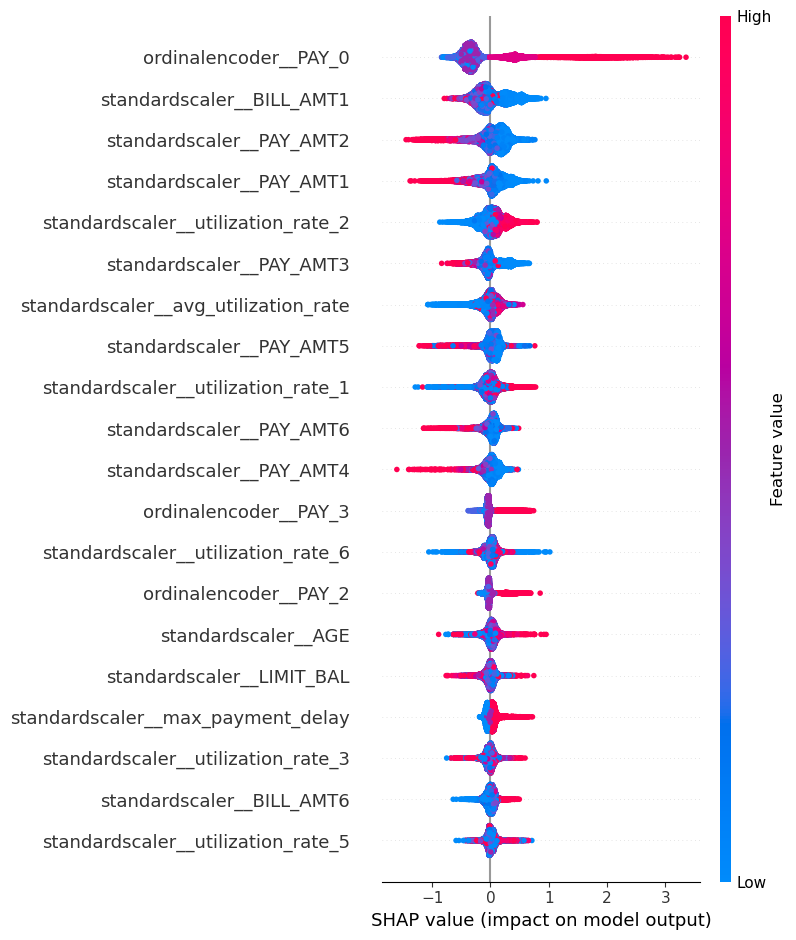

In [40]:
best_lgbm_model = randomized_search.best_estimator_.named_steps['lgbmclassifier']
explainer = shap.TreeExplainer(best_lgbm_model)
X_train_transformed = randomized_search.best_estimator_.named_steps['columntransformer'].transform(X_train)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed, feature_names=randomized_search.best_estimator_.named_steps['columntransformer'].get_feature_names_out())

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Results on the test set <a name="12"></a>


The accuracy and F1 score does agree with the validation scores from before, but unfortunately the F1 score is not very high. The low F1 score indicates that it may not generalize well to unseen data, so I cannot completely trust it. However, it is reassuring that the model is reliable seeing as the train and test scores are similar. This dataset is very hard to predict on; there are not a lot of defining or significant features that can truly make it easy to predict whether someone will default or not. Perhaps there can be some more optimizations in terms of recall and precision to push the F1 score to be a little bit higher.

In terms of optimization bias, there is a chance that there are issues with it. The test set was kept separate all this time which helps to prevent optimization bias; however, there was lots of hyperparameter tuning and the validation data was used multiple times to evaluate different models, which could've led to bias. Overall, I'm not too surprised that the F1 score was lower than what was seen in the training/validation sets.

In [41]:
pipe_lgbm_best.fit(X_train, y_train)
y_pred = pipe_lgbm_best.predict(X_test)


In [42]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

pd.DataFrame({
    'Accuracy': [accuracy_score(y_test, y_pred)],
    'F1': [f1_score(y_test, y_pred)]
})


,Accuracy,F1
0,0.770889,0.526412


/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


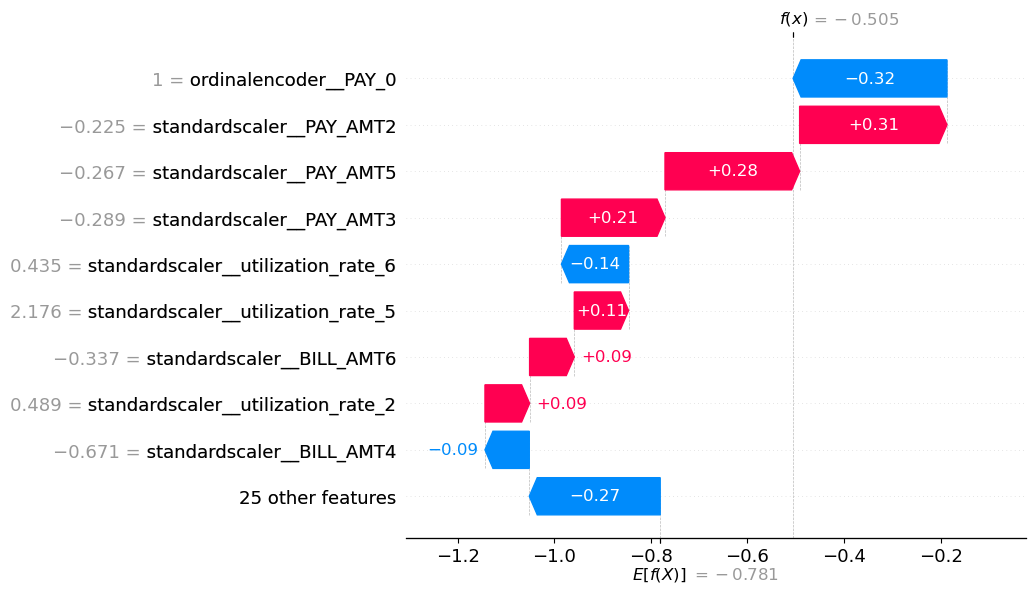

In [43]:
lgbm_model = pipe_lgbm_best.named_steps['lgbmclassifier']
explainer = shap.TreeExplainer(lgbm_model)

X_instance = X_test.iloc[0:1]  
X_instance_transformed = pipe_lgbm_best.named_steps['columntransformer'].transform(X_instance)

shap_values_instance = explainer.shap_values(X_instance_transformed)

shap.initjs()
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_instance[0],              
        base_values=explainer.expected_value,        
        data=X_instance_transformed[0],                 
        feature_names=pipe_lgbm_best.named_steps['columntransformer'].get_feature_names_out()  
    )
)

For this individual prediction represented by a SHAP waterfall plot, it can be seen that it is predicting it to be a non-defaulting person. The PAY_0 feature is the feature that influences the prediction the most, pushing the prediction value by -0.32. PAY_AMT2, PAY_AMT5, and PAY_AMT3 all contribute to a higher risk score. It appears lower than average payment amounts appear to increase the risk of someone defaulting. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## Summary of results <a name="13"></a>
<hr>


In [44]:
results = {
    'Tuned Logistic Regression': {
        'fit_time': '0.058 (+/- 0.002)',
        'score_time': '0.007 (+/- 0.000)',
        'test_accuracy': '0.737 (+/- 0.009)',
        'train_accuracy': '0.738 (+/- 0.002)',
        'test_f1': '0.519 (+/- 0.012)',
        'train_f1': '0.519 (+/- 0.002)',
        'Final Notes': 'Good F1 score, but not as great as LightGBM'
    },
    'Tuned DecisionTree': {
        'fit_time': '0.350 (+/- 0.007)',
        'score_time': '0.008 (+/- 0.001)',
        'test_accuracy': '0.819 (+/- 0.008)',
        'train_accuracy': '0.834 (+/- 0.001)',
        'test_f1': '0.485 (+/- 0.022)',
        'train_f1': '0.525 (+/- 0.009)',
        'Final Notes': 'Decent F1 and accuracy score, but slower fit time'
    },
    'Tuned kNN': {
        'fit_time': '0.030 (+/- 0.004)',
        'score_time': '0.060 (+/- 0.008)',
        'test_accuracy': '0.809 (+/- 0.006)',
        'train_accuracy': '0.827 (+/- 0.001)',
        'test_f1': '0.454 (+/- 0.017)',
        'train_f1': '0.506 (+/- 0.003)',
        'Final Notes': 'Quick, but has the worst test and F1 scores'
    },
    'Tuned LightGBM': {
        'fit_time': '1.482 (+/- 0.012)',
        'score_time': '0.022 (+/- 0.001)',
        'test_accuracy': '0.775 (+/- 0.006)',
        'train_accuracy': '0.916 (+/- 0.002)',
        'test_f1': '0.533 (+/- 0.012)',
        'train_f1': '0.834 (+/- 0.004)',
        'Final Notes': 'Slow, Highest F1 score, overfitting likely'
    }
}

# Convert to DataFrame and transpose
df = pd.DataFrame(results).T

# Reorder columns if desired
columns_order = ['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 
                'test_f1', 'train_f1', 'Final Notes']
df = df[columns_order]


# Optional: Rename columns for better readability
df.columns = ['Fit Time', 'Score Time', 'Test Accuracy', 'Train Accuracy', 
              'Test F1', 'Train F1', 'Final Notes']

# Display the DataFrame
display(df)

from IPython.display import display, Markdown

# Create the DataFrame
final_test_scores = pd.DataFrame({
    'Accuracy': [accuracy],
    'F1': [f1]
})

# Display the title using Markdown
display(Markdown("### Final Test Scores Using LGBM"))
# Display the DataFrame
display(final_test_scores)

,Fit Time,Score Time,Test Accuracy,Train Accuracy,Test F1,Train F1,Final Notes
Tuned Logistic Regression,0.058 (+/- 0.002),0.007 (+/- 0.000),0.737 (+/- 0.009),0.738 (+/- 0.002),0.519 (+/- 0.012),0.519 (+/- 0.002),"Good F1 score, but not as great as LightGBM"
Tuned DecisionTree,0.350 (+/- 0.007),0.008 (+/- 0.001),0.819 (+/- 0.008),0.834 (+/- 0.001),0.485 (+/- 0.022),0.525 (+/- 0.009),"Decent F1 and accuracy score, but slower fit time"
Tuned kNN,0.030 (+/- 0.004),0.060 (+/- 0.008),0.809 (+/- 0.006),0.827 (+/- 0.001),0.454 (+/- 0.017),0.506 (+/- 0.003),"Quick, but has the worst test and F1 scores"
Tuned LightGBM,1.482 (+/- 0.012),0.022 (+/- 0.001),0.775 (+/- 0.006),0.916 (+/- 0.002),0.533 (+/- 0.012),0.834 (+/- 0.004),"Slow, Highest F1 score, overfitting likely"


### Final Test Scores Using LGBM

,Accuracy,F1
0,0.770889,0.526412


Conclusion:

Training Models

Tuned Decision Tree achieved the highest test accuracy (0.819) while Tuned LightGBM achieved the highest F1 score (0.533) and most models show similar accuracy with the exception of the much lower accuracy for tuned logistic regression. With the prioritization of the F1 score, Tuned LightGBM is the best choice despite the likelihood of overfitting. For a better balance between speed and F1 score, logistic regression might be a better choice.

LightGBM models are complex but perform well, and take longer to fit, but produce a high F1 score. Tuning improved F1 scores but often at cost of accuracy as shown in Logistic Regression and LightGBM. The accuracy scores were much higher prior to tuning to F1 scores. 


Features

Payment status (PAY_0) is by far the most influential predictor for an individual defaulting and recent payment amounts (PAY_AMT2, PAY_AMT5, PAY_AMT3) also are impactful but less so. 

Overall

LGBM was chosen as the model due to its stronger F1 score performance. The F1 score overall is not very high so I cannot be too confident in the model being able to predict real life data. Since this dataset is on credit card defaulting, there is likely more importance placed on false negatives (predicting will not default, when they will) as this would be loss for a credit institution. The F1 score is 0.53 which indicates that it can predict sometimes, but improvements are necessary as false negatives are quite important. However, it is a fairly consistent model as the training and test scores are not too different.


Improvements

Other gradient tree models(i.e catboost) and the RandomTreeClassifier model could be tested to see if they might improve upon the LightGBM model. Additionally, maybe stacking different models could result in an even better predictor for the test set. An ROC curve chart may also provide us with more information since this data is so largely imbalanced. I think AUC graph would be interesting to look at as well. Perhaps we could get better results by changing the threshold. 
Additional feature engineering could be done that could further improve the results such as adding payment status and the bill amount. We have only added two features here which seem to not play too large a factor in determining whether a person defaults or not. 

<!-- END QUESTION -->

<br><br>

<br><br>